# Do bruteforce to find optimal

In [381]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.linalg import expm
import itertools
import time
import tqdm
matplotlib.font_manager.fontManager.addfont("fonts/ipag.ttf")
matplotlib.rcParams['font.family'] = 'IPAGothic'

In [382]:
# Common functions and constants

total_time = (1/3)*np.pi # ns
n_steps = 5
dt = total_time / n_steps

# Pauli matrices
sx = np.array([[0, 1], [1, 0]], dtype=np.complex128)
sy = np.array([[0, -1j], [1j, 0]], dtype=np.complex128)
sz = np.array([[1, 0], [0, -1]], dtype=np.complex128)


up = np.array([[1], [0]], dtype=np.complex128)    # |0⟩
down = np.array([[0], [1]], dtype=np.complex128)

## Single Qubit

In [383]:
# Define the Hamiltonian
H_controls_single = [sx/2, sy/2, sz/2]
H_drift = np.zeros((2,2))

In [384]:
# Functions
# Simulation function
def simulate_sequence(sequence, H_controls, initial_state, dt):
    state = initial_state.copy()
    for idx in sequence:
        H = H_controls[idx]
        U = expm(-1j * H * dt)
        state = U @ state
    return state

# Calculate the fidelity
def calculate_fidelity(state, target_state):
    return np.abs(np.dot(state.conj().T, target_state))**2

# Brute force
def brute_force(H_drift, H_list, initial_state, target_state, total_time, n_steps):
    num_controls = len(H_list)
    all_sequences = list(itertools.product(range(num_controls), repeat=n_steps))

    best_fidelity = -1
    best_sequence = None
    best_final_state = None

    for sequence in all_sequences:
        final_state = simulate_sequence(sequence, H_list, initial_state, dt)
        F = calculate_fidelity(final_state, target_state)
        from tqdm.notebook import tqdm

        if F > best_fidelity:
            best_fidelity = F
            best_sequence = sequence
            best_final_state = final_state

    return best_sequence, best_fidelity, best_final_state
        

In [385]:
# Run the brute force
best_sequence, best_fidelity, best_final_state = brute_force(H_drift, H_controls_single, up, down, total_time, n_steps)

In [386]:
# Show the result
print(f"Best sequence: {best_sequence}")
print(f"Best fidelity: {best_fidelity}")


Best sequence: (0, 0, 0, 0, 0)
Best fidelity: [[0.25]]


## Double Qubits

In [387]:
# 2キュービット用のパウリ行列とアイデンティティ
I = np.eye(2, dtype=np.complex128)
sx = np.array([[0, 1], [1, 0]], dtype=np.complex128)
sy = np.array([[0, -1j], [1j, 0]], dtype=np.complex128)
sz = np.array([[1, 0], [0, -1]], dtype=np.complex128)

# Ising Modelのコントロールハミルトニアン
XII = np.kron(sx, I) / 2
YI = np.kron(sy, I) / 2
IX = np.kron(I, sx) / 2
IY = np.kron(I, sy) / 2
ZZ = np.kron(sz, sz) / 2

H_controls_two = [XI, YI, IX, IY, ZZ]
H_drift_two = np.zeros((4, 4), dtype=np.complex128)

# 2キュービット状態の定義
up_up = np.kron(up, up)      # |00⟩
up_down = np.kron(up, down)  # |01⟩
down_up = np.kron(down, up)  # |10⟩
down_down = np.kron(down, down)  # |11⟩

In [388]:
# Calculate the fidelity
def calculate_fidelity_2q(state, target_state):
    return np.abs(np.dot(state.conj().T, np.kron(target_state, up)))**2 + np.abs(np.dot(state.conj().T, np.kron(target_state.conj(), down)))**2

# Brute force
def brute_force_2q(H_drift, H_list, initial_state, target_state, total_time, n_steps):
    num_controls = len(H_list)
    all_sequences = list(itertools.product(range(num_controls), repeat=n_steps))

    best_fidelity = -1
    best_sequence = None
    best_final_state = None

    for sequence in all_sequences:
        final_state = simulate_sequence(sequence, H_list, initial_state, dt)
        F = calculate_fidelity_2q(final_state, target_state)

        if F > best_fidelity:
            best_fidelity = F
            best_sequence = sequence
            best_final_state = final_state

    return best_sequence, best_fidelity, best_final_state

In [389]:
# 2キュービット版のBrute Force実行
initial_state_2q = up_up      # |00⟩から開始
target_state = down   # |11⟩を目標

# パラメータ設定
n_steps_2q = 2
total_combinations = len(H_controls_two) ** n_steps_2q
print(f"総組み合わせ数: {total_combinations}")

# Brute Force実行
best_sequence_2q, best_fidelity_2q, best_final_state_2q = brute_force_2q(
    H_drift_two, 
    H_controls_two, 
    initial_state_2q, 
    target_state, 
    total_time, 
    n_steps=n_steps
)


総組み合わせ数: 25


In [390]:
print(f"\n=== 2キュービット結果 ===")
print(f"ベストシーケンス: {best_sequence_2q}")
print(f"ベストフィデリティ: {best_fidelity_2q}")

# コントロール名を表示
control_names = ['XI', 'YI', 'IX', 'IY', 'ZZ']
sequence_names = [control_names[i] for i in best_sequence_2q]
print(f"ベストシーケンス名: {' -> '.join(sequence_names)}")


=== 2キュービット結果 ===
ベストシーケンス: (0, 0, 0, 0, 0)
ベストフィデリティ: [[0.25]]
ベストシーケンス名: XI -> XI -> XI -> XI -> XI


n_stepsごとのシミュレーション:   0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_64640/1365786151.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fid_1q_val = float(best_fid_1q) if isinstance(best_fid_1q, np.ndarray) else best_fid_1q
/tmp/ipykernel_64640/1365786151.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fid_2q_val = float(best_fid_2q) if isinstance(best_fid_2q, np.ndarray) else best_fid_2q


n_steps=1: 1Q Fidelity=0.010926, 2Q Fidelity=0.010926
n_steps=2: 1Q Fidelity=0.043227, 2Q Fidelity=0.043227
n_steps=3: 1Q Fidelity=0.095492, 2Q Fidelity=0.095492
n_steps=4: 1Q Fidelity=0.165435, 2Q Fidelity=0.165435


n_stepsごとのシミュレーション: 100%|██████████| 5/5 [00:00<00:00, 11.85it/s]

n_steps=5: 1Q Fidelity=0.250000, 2Q Fidelity=0.250000


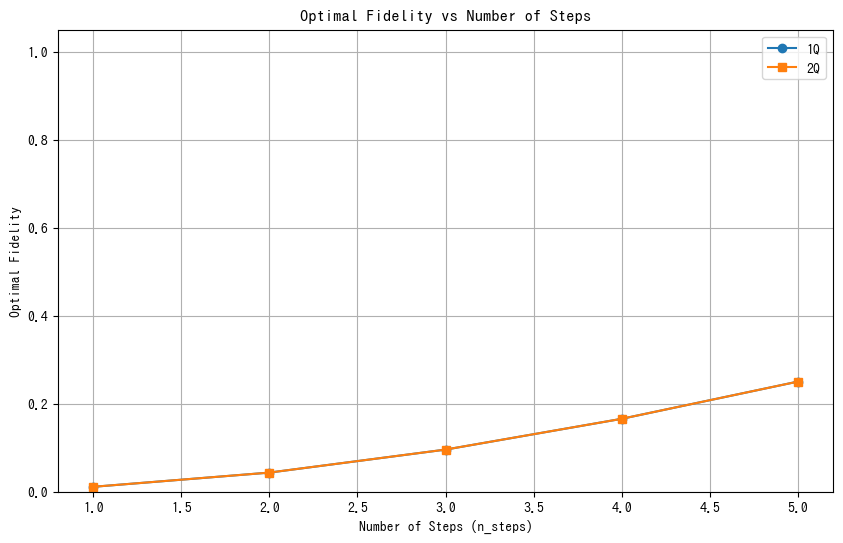

,n_steps,1Q Fidelity,2Q Fidelity
0,1,0.010926,0.010926
1,2,0.043227,0.043227
2,3,0.095492,0.095492
3,4,0.165435,0.165435
4,5,0.250000,0.250000


In [392]:
# 1キュービットと2キュービットのシミュレーション結果をプロット
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

# n_stepsの範囲
n_steps_range = range(1, 6)  # 1から5まで
total_time = (1/3)*np.pi # ns

# 結果を格納する配列
single_qubit_fidelities = []
two_qubit_fidelities = []

# 各n_stepsでシミュレーションを実行
for n in tqdm(n_steps_range, desc="n_stepsごとのシミュレーション"):
    # 1キュービット
    best_seq_1q, best_fid_1q, _ = brute_force(
        H_drift, H_controls_single, up, down, total_time, n_steps=n
    )
    # numpy配列をスカラー値に変換
    fid_1q_val = float(best_fid_1q) if isinstance(best_fid_1q, np.ndarray) else best_fid_1q
    single_qubit_fidelities.append(fid_1q_val)
    
    # 2キュービット
    best_seq_2q, best_fid_2q, _ = brute_force_2q(
        H_drift_two, H_controls_two, initial_state_2q, target_state, total_time, n_steps=n
    )
    # numpy配列をスカラー値に変換
    fid_2q_val = float(best_fid_2q) if isinstance(best_fid_2q, np.ndarray) else best_fid_2q
    two_qubit_fidelities.append(fid_2q_val)
    
    print(f"n_steps={n}: 1Q Fidelity={fid_1q_val:.6f}, 2Q Fidelity={fid_2q_val:.6f}")

# プロット
plt.figure(figsize=(10, 6))
plt.plot(list(n_steps_range), single_qubit_fidelities, 'o-', label='1Q')
plt.plot(list(n_steps_range), two_qubit_fidelities, 's-', label='2Q')
plt.xlabel('Number of Steps (n_steps)')
plt.ylabel('Optimal Fidelity')
plt.title('Optimal Fidelity vs Number of Steps')
plt.grid(True)
plt.legend()
plt.ylim(0, 1.05)
plt.show()

# 結果をテーブルとして表示
from IPython.display import display, HTML
import pandas as pd

results_df = pd.DataFrame({
    'n_steps': list(n_steps_range),
    '1Q Fidelity': single_qubit_fidelities,
    '2Q Fidelity': two_qubit_fidelities
})

display(results_df)
